In [1]:
from __future__ import division
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ## Beautiful Plots :)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import re
import operator
import datetime
from collections import Counter
from nltk import ngrams
from utils import *
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [4]:
class Random_Acts_Of_Pizza(object):
    """
    This class takes in a dataframe from "Random Acts Of Pizza"
    and creates a set of features for each requests present in
    the data. The features can be explicitly accessed with the 
    help of methods of this class.
    """
    
    def __init__(self,dataframe):
        """
        The input is a dataframe. We have explicitly used
        data provided from the Kaggle competition named as
        Random Acts Of Pizza.
        Link : https://www.kaggle.com/c/random-acts-of-pizza/data
        """
        self.df = dataframe
    
    def __str__(self):
        return str(self.df.info())
    
    def get_narrative(self,col,narrative):
        """
        Takes in input as the column and a lexicon for
        the narrative. The lexicon is in the form of a 
        dictionary where key in the narrative and value
        is a string containing all words relating to the
        narrative.
        Outputs a list containing narrative score for
        each request
        """
        request_narrative,narration = [],[]
        for request in self.df[col]:
            word_count = {'Money':0,'Job':0,'Student':0,'Family':0,'Craving':0}
            n = 0
            for word in request.split():
                for lexicon in narrative:
                    if word in narrative[lexicon]:
                        word_count[lexicon] += 1
            narration.append(max(word_count.iteritems(), key=operator.itemgetter(1))[0])
        print 'Use get_dummies to encode the features as binary'
        return narration
    
    def get_politeness(self,col,polite_words):
        """
        Takes in input as the column for which politeness
        needs to be calculated.
        Output is a list of floats for each request where
        each float corresponds to the politeness score for
        each request.
        """
        count,politeness = 0,[]
        for request in self.df[col]:
            count += 1
            request_ngrams = []
            for grams in ngrams(request.split(),3):
                request_ngrams.append(' '.join(grams))
            for grams in ngrams(request.split(),2):
                request_ngrams.append(' '.join(grams))
            request_words = set(request.split())
            request_ngrams = set(request_ngrams)
            num = len(request_words.intersection(set(polite_words))) +\
            len(request_ngrams.intersection(set(polite_words)))
            try:
                politeness.append(float(num)/len(request_words))
            except:
                politeness.append(0.0)
        print 'Total Number of request parsed: ',count
        return politeness
    
    def get_length(self,col):
        """
        Takes input as the column name(for the request)
        Outputs the length 
        """
        return [len(x.split()) for x in self.df[col]]
    
    def get_karma(self):
        """
        Calculate the karma score for each user of the
        RAOP.
        Output is a list of karma score for each requester.
        """
        karma = self.df['requester_upvotes_plus_downvotes_at_request']+\
        self.df['requester_upvotes_plus_downvotes_at_retrieval']
        return karma
    
    def get_score(self):
        """
        Calculates the score of each user of RAOP.
        Output is a list of score for each user.
        """
        score = self.df['requester_upvotes_minus_downvotes_at_request']+\
        self.df['requester_upvotes_minus_downvotes_at_retrieval']
        return score
    
    def get_evidentiality(self,col):
        """
        We count the occur- rences of http links, image links,
        and “proof”/“prove”
        Returns a list of number of urls for each request.
        """
        urls = []
        for text in self.df[col]:
            url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
            urls.append(len(url))
        return urls
    
    def get_complexity(self,col):
        """
        Takes input as the column of request and calculate
        the complexity score given by Flesch-Kincaid Grade 
        Level.
        Returns a list of complexity score for each request.
        """
        grade_level = []
        syl = set(['a','e','i','o','u'])
        for text in self.df[col]:
            sent_cnt = len(text.split('.'))
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            syl_count = 0
            for word in words:
                for letter in list(word):
                    if letter in syl:
                        syl_count += 1
            grade_level.append(Flesch_reading_ease(total_sentences = sent_cnt,total_words = len(words),\
                                                   total_sylabls=syl_count))
        return grade_level
    
    def spell_check_score(self,col):
        """
        We further use a spell-checker to identify misspelled 
        words in the request text [10]. In other contexts 
        (e.g. Kickstarter), spelling errors have been found to
        have a negative impact on funding success.
        
        Input is the column of request.
        Returns a list of spelling check score for each
        request
        """
        spell_errors = []
        for text in self.df[col]:
            spl_err = 0
            words = re.sub("["+'!"#$%&\'()*+.,-/:;<=>?@[\\]^_`{|}~'+"]", " ", text).split()
            if len(words):
                for word in words:
                    if correction(word)!= word: 
                        spl_err += 1
                spell_errors.append(float(spl_err)/len(words))
            else:
                spell_errors.append(0)
        return spell_errors
    
    def first_half_of_month(self,col):
        """
        Input is the column containing the timestamp
        Returns the day of the timestamp for a request
        """
        return [datetime.datetime.fromtimestamp(int(timestamp)).day \
                for timestamp in self.df[col]]
    
    def get_popularity(self,col):
        """
        Input is the column containing the total upvotes
        the request got at time of retrieval
        """
        return self.df[col]
    
    def get_usersimilarity(self , col):
        store = []
        """
        Input:
            column containing username of requesters
        Output:
            score : Their similarity score based on interactions in common
            subreddits between requester and  giver user
        """
        for i in self.df[col]:
            ls = list(self.df[self.df.requester_username == i].requester_subreddits_at_request)
            giver_ = list(self.df[self.df.requester_username == i].giver_username_if_known)
            score = 0
            if len(ls[0]) and giver_[0] != "N/A":
                for j in ls[0]:
                    a = get_post_from_subreddit_by_user(i , j)
                    b = get_post_from_subreddit_by_user(giver_[0] , j)
                    if a != 0 and b != 0:
                        score += (a+b)
            store.append(score)
        return store
    def get_age(self):
        """
        Input : void
        Output : A panda series having the age of account
        (present in dataset already)
        """
        return df['requester_days_since_first_post_on_raop_at_request']
    
    def get_activity(self):
        """
        Input : void
        Output : A panda series having the activity of account
        (present in dataset already)
        """
        return self.df['requester_number_of_subreddits_at_request']
    
    def train_model(self,data,model,response_col,scoring='roc_auc',cv=10):
        """
        Input:
            data : new morphed data frame
            model : the model on which data is to be trained.
            response_col : name of column to be used as
            response
            cv : number of cross validation scores
            scoring : method of scoring
        Output:
            score : k-fold cv score for the model
        """
        global id_,df_
        data_copy = data.copy()
        y = data_copy.pop(response_col)
        scores = cross_val_score(model,data_copy,y,scoring=scoring,cv=cv)
        del data_copy # Dataframe may be too large
        gc.collect() # Explicitly collecting the garbage
        return scores.mean()
    
    def train_test_model(self,data,y,model):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)
        model.fit(X_train,y_train)
        y_ = model.predict(X_test)
        return roc_auc_score(y_test,y_)

    

In [5]:


df = pd.read_json('~/Desktop/RAOP/train.json')
requests = 'request_text_edit_aware'

In [6]:
raop = Random_Acts_Of_Pizza(df)
print raop

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 32 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

In [7]:
## Calculating all the features
narrative_topics = raop.get_narrative(col=requests,narrative=narrative)
df['narrative_topics'] = narrative_topics
df = pd.get_dummies(df,columns=['narrative_topics'])
df['politeness'] =  raop.get_politeness(col=requests,polite_words=polite_words)
df['request_length'] = raop.get_length(requests)
df['karma'] = raop.get_karma()
df['scores'] = raop.get_score()
df['trust'] = raop.get_evidentiality(requests)
df['complexity'] = raop.get_complexity(requests)
df['popularity'] = raop.get_popularity('number_of_upvotes_of_request_at_retrieval' )
df['age'] = raop.get_age()
df['first_half_of_month'] = pd.Series(raop.first_half_of_month('unix_timestamp_of_request')) < 15
df['activity'] = raop.get_activity()

Use get_dummies to encode the features as binary
Total Number of request parsed:  4040


In [8]:
if not os.path.isfile('data/spellCheck.csv'):
    df['spell_check_score'] = raop.spell_check_score(requests)
    df['spell_check_score'].to_csv('spellCheck.csv')
    print df.spell_check_score.head(2)
else:
    print 'File exists...'
    df['spell_check'] = pd.read_csv('data/spellCheck.csv',index_col=0,header=None)

File exists...


In [9]:
# Sanity Check
for fname in ['similarity.csv','sentiment.csv','indegree.csv','outdegree.csv','shapley.csv']:
    fname = 'data/'+fname
    if not os.path.isfile(fname):
        print "{} file doesn't exists..."
        raise
print 'All files exists..'

All files exists..


In [10]:
df['similarity'] = pd.read_csv('data/similarity.csv',index_col=0,header=None)
df['sentiment'] = pd.read_csv('data/sentiment.csv',index_col=0,header=None).iloc[:4040,-1].fillna(0)
df['giver'] = df['giver_username_if_known'].map({'N/A':0}).fillna(1)
df = df.merge(pd.read_csv('data/indegree.csv',names=['requester_username','indegree'],header=None))
df = df.merge(pd.read_csv('data/shapley.csv',names=['requester_username','shapley'],header=None))
df = df.merge(pd.read_csv('data/outdegree.csv',names=['requester_username','outdegree'],header=None))

In [11]:
req_features = [
 'complexity',
 'first_half_of_month',
 'karma',
 'narrative_topics_Craving',
 'narrative_topics_Family',
 'narrative_topics_Job',
 'narrative_topics_Money',
 'narrative_topics_Student',
 'politeness',
 'popularity',
 'request_length',
 'scores',
 'trust',
 'requester_received_pizza',
 'similarity',
 'sentiment',
 'giver',
 'activity',
 'age',
 'indegree',
 'outdegree',
 'shapley',
 'subreddit_popularity'
]


In [12]:
df_new = df.drop([col for col in df.columns if col not in req_features],axis=1)
df_new.head(2)

,requester_received_pizza,narrative_topics_Craving,narrative_topics_Family,narrative_topics_Job,narrative_topics_Money,narrative_topics_Student,politeness,request_length,karma,scores,...,popularity,age,first_half_of_month,activity,similarity,sentiment,giver,indegree,shapley,outdegree
0,False,0,1,0,0,0,0.0,67,1,1,...,1,0.0,True,0,0,2.250,0.0,0,0.0,0
1,False,0,0,0,1,0,0.0,16,11284,4292,...,5,0.0,False,12,0,0.375,0.0,0,0.0,0


## Overlapping requesters

In [13]:
from collections import defaultdict
import operator
from sklearn.preprocessing import StandardScaler,scale,normalize
sub = df['requester_subreddits_at_request']
freq_sub = defaultdict(int)
for s in sub:
    for j in s:
        freq_sub[j] += 1
        
get_freq_max = sorted(freq_sub.items(), key=operator.itemgetter(1),reverse=True)

ls=[]
for idx in xrange(4040):
    rank=0
    for red_it in df.loc[idx]['requester_subreddits_at_request']:
        rank+=freq_sub[red_it]
    ls.append(rank)

df['subreddit_popularity'] = ls

total = sum(ls)


def get_overlap(val):
    return val/total

#df.subreddit_popularity =df.subreddit_popularity.map(get_overlap) 

df.subreddit_popularity = StandardScaler().fit_transform(df.subreddit_popularity)
df.subreddit_popularity



0      -1.154881
1      -0.373234
2      -1.154881
3      -0.454986
4      -0.542473
5       1.226736
6      -1.154881
7       0.665540
8       0.272649
9      -0.847210
10      1.014687
11     -1.154881
12     -1.154881
13      0.335997
14     -0.556076
15      1.027090
16     -0.417511
17     -0.922694
18     -0.084634
19      0.613394
20     -1.154881
21      1.523071
22     -0.897222
23     -1.154881
24      0.469761
25     -1.132743
26     -0.849877
27     -1.154881
28      0.431085
29     -0.002215
          ...   
4010   -0.219465
4011    1.395575
4012    0.602058
4013    2.238837
4014    0.463760
4015   -1.154881
4016    0.973878
4017   -0.134245
4018    0.579386
4019   -1.154881
4020    1.527472
4021    0.510704
4022    0.273449
4023    0.936269
4024    0.204900
4025    2.128544
4026    1.360100
4027   -0.241070
4028    1.204064
4029    1.120711
4030    0.277717
4031    0.024458
4032    0.564983
4033    0.883590
4034   -0.737318
4035   -1.154881
4036    1.003084
4037    0.6359

In [14]:
y=df['requester_received_pizza'].astype(int)
X = df_new

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1',tol=1e-4,C=0.8,intercept_scaling=1.)
auc_score = raop.train_model(df_new,model=model,response_col='requester_received_pizza')
acc_score = raop.train_model(df_new,model=model,response_col='requester_received_pizza',scoring='accuracy')

auc_again = raop.train_test_model(X,y,model)

In [16]:
print 'ROC Score: {}'.format(auc_score*100)
print 'Accuracy Score: {}'.format(acc_score*100)

print 'ROC score {}'.format(auc_again*100)

ROC Score: 80.3525834706
Accuracy Score: 81.857144937
ROC score 100.0


### COMPARISON MODELS 

In [22]:
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import SGDClassifier   
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#import xgboost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier

classifiers=[
    (LogisticRegression(penalty='l1'),"LR"),
    #(KNeighborsClassifier(5),"KNC"),
    (SVC(),'SVC'),
    #(QuadraticDiscriminantAnalysis(),'QDA'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'RFC'),
    #(AdaBoostClassifier(),'ADC'),
    #(SGDClassifier(),'SGDC'),
    #(DecisionTreeClassifier(max_depth=5),'DTC'),
    #(xgboost.XGBClassifier(learning_rate=0.1),'XGB'),
    (LinearDiscriminantAnalysis(),'LDA'),
    #(GaussianNB(),'GNB')
]

In [23]:
score_ , names = [] , []
for model,name in classifiers:
    score = raop.train_model(df_new,model=model,response_col='requester_received_pizza')
    score_.append(score)
    names.append(name)
    print 'ROC Score: {}'.format(score*100) , name

ROC Score: 80.2919361867 LR
ROC Score: 57.989706295 SVC
ROC Score: 77.9173680942 RFC
ROC Score: 80.3817197427 LDA


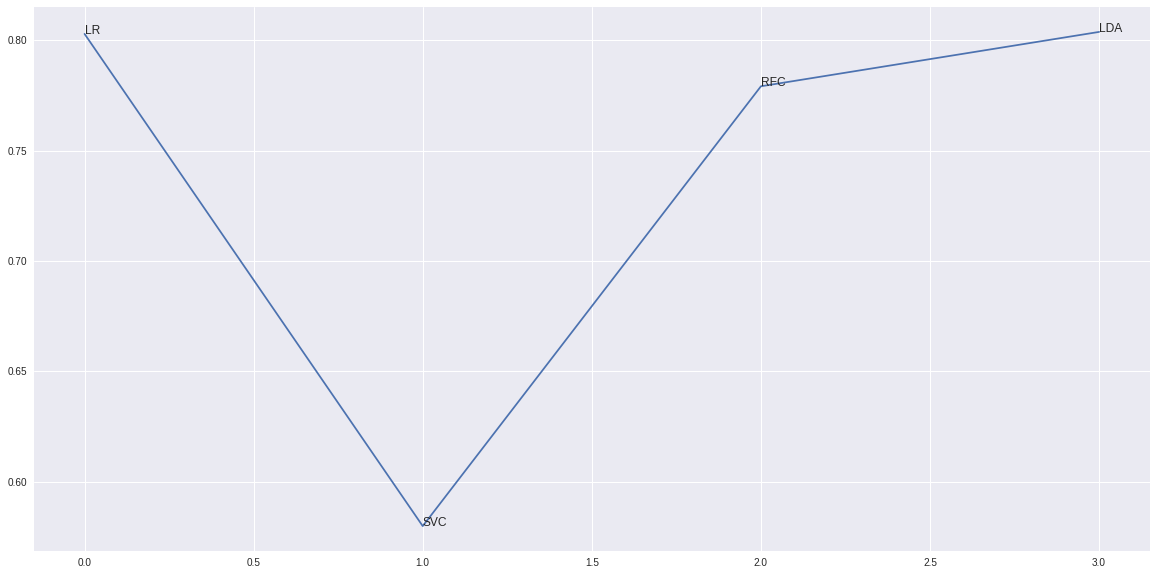

In [24]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
A = score_[:]
plt.plot(A)
for i, label in enumerate(names):
    plt.text(i,A[i], label) 
plt.savefig('comparison.png')
plt.show()

### Significance chart of the features
![Significance Chart](data/feature_significance.png "Title")

## Community Overlapping 

In [21]:
graph1 = pd.read_csv("~/Random_Acts_Of_Pizza/data/graph.txt",names=['to-fro'])

In [186]:
from sklearn.preprocessing import LabelEncoder
import re
graph = pd.DataFrame(columns=['commenter','requester_username'])
froms,to=[],[]
for i in xrange(4040):
    a = graph1.loc[i]['to-fro'].split(':')
    for j in re.findall(r"[\w']+",a[1]):
        froms.append(j);to.append(a[0])
    froms.append('')
    to.append(a[0])
graph.commenter = froms
print len(set(froms))
print len(set(to))
graph.requester_username  = to
all_users = graph.commenter.append(graph.requester_username)
all_users = LabelEncoder().fit_transform(all_users)
print np.amax(all_users)
print len(set(all_users))
graph["from_commenter"] = all_users[:8516]
graph["to_requester"]   = all_users[8516:]

c=set(df.requester_username)
graph

2381
4040
5923
5924


,commenter,requester_username,from_commenter,to_requester
0,RAoPBot,scoobydo0,1679,5102
1,,scoobydo0,0,5102
2,,pzero,0,4838
3,Publius0,Publius0,1659,1659
4,jesses_girl,Publius0,3896,1659
5,RAoPBot,Publius0,1679,1659
6,FlailStorm,Publius0,722,1659
7,,Publius0,0,1659
8,,joshoutloud,0,3944
9,ReillyBoy,captainguinness,1726,2857


In [187]:
graph_vals = df[['requester_username','indegree','outdegree','request_number_of_comments_at_retrieval','requester_number_of_comments_at_retrieval','requester_number_of_comments_in_raop_at_retrieval']]
graph_vals = pd.merge(graph_vals,graph,on='requester_username')

def wt(val):
    if not val: return 100
    else: return 1/val
graph_vals['weight'] = graph_vals['request_number_of_comments_at_retrieval'].map(wt)

graph_vals

,requester_username,indegree,outdegree,request_number_of_comments_at_retrieval,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_retrieval,commenter,from_commenter,to_requester,weight
0,nickylvst,0,0,0,0,0,,0,4583,100.000000
1,fohacidal,0,0,0,1000,0,,0,3437,100.000000
2,jacquibatman7,0,0,0,0,0,,0,3843,100.000000
3,4on_the_floor,2,0,4,41,2,arbiterxero,2577,40,0.250000
4,4on_the_floor,2,0,4,41,2,alliOops,2497,40,0.250000
5,4on_the_floor,2,0,4,41,2,,0,40,0.250000
6,Futuredogwalker,1,0,5,178,4,hurley77891,3716,764,0.200000
7,Futuredogwalker,1,0,5,178,4,,0,764,0.200000
8,jamespweb,0,0,0,68,1,,0,3849,100.000000
9,usftampa,2,1,3,8,8,usftampa,5680,5680,0.333333


### Plot Interaction Graph

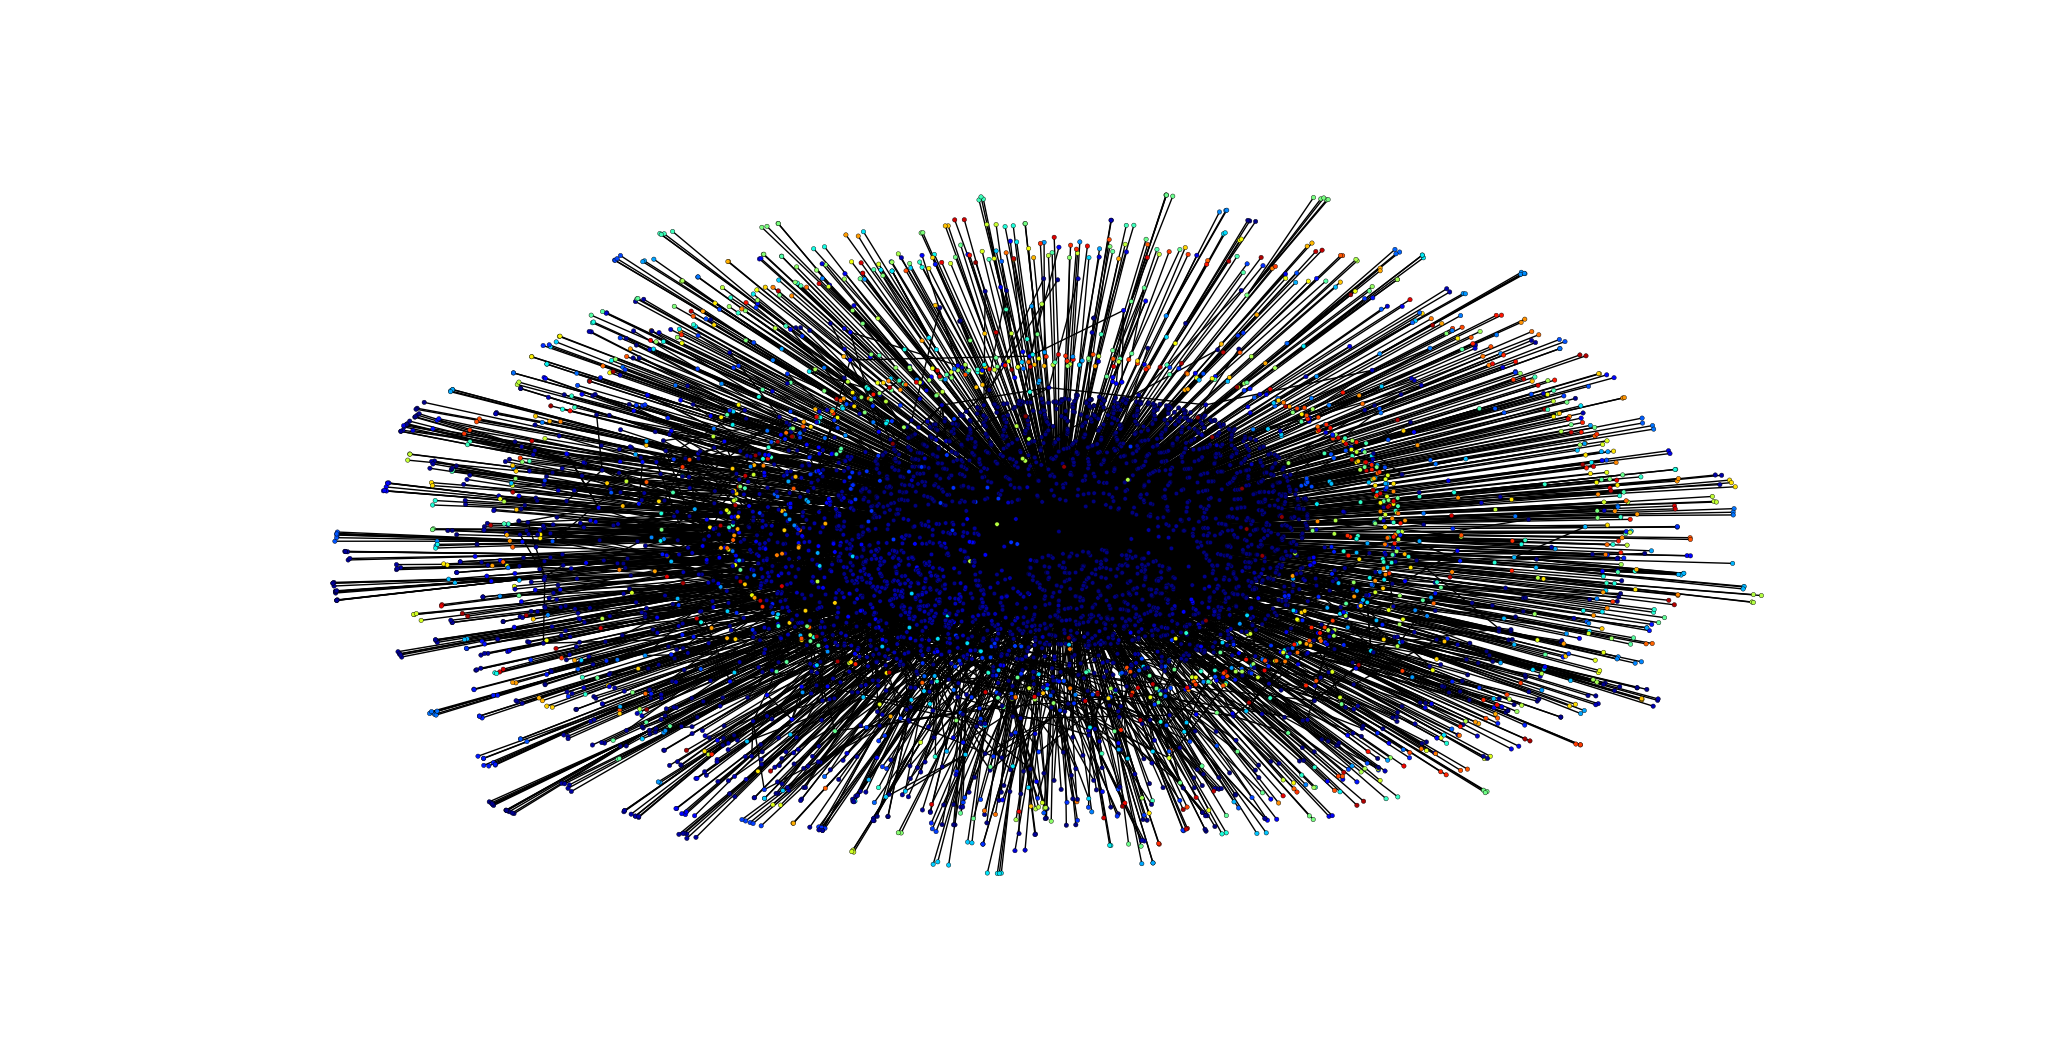

In [209]:
import sys
sys.path.append('/home/killerbeast/anaconda2/lib/python2.7/site-packages/python_louvain-0.4-py2.7.egg/community')
import networkx as nx
import community
g = nx.Graph()

for i in xrange(8516):
    g.add_edge(graph.loc[i]['from_commenter'],graph.loc[i]['to_requester'],weight = 1.)

nx.transitivity(g)
partition = community.best_partition(g)
mod = community.modularity(partition,g)


values = [partition.get(node) for node in g.nodes()]
nx.draw_spring(g,cmap=plt.get_cmap('jet'),node_color = values, node_size = 10, with_labels = False)

plt.savefig('graph.png')
plt.show()

In [210]:
triads = nx.transitivity(g)
triads

3.441825752544556e-05

In [211]:
mod

0.5231113757663672

### Centrality Features


In [164]:
#create graph using snap and igraph
from igraph import *

G = Graph(directed=True)
G.add_vertices(5924)

edge_list =[]
for i in xrange(8516):
    edge_list.append(((graph.loc[i]['from_commenter'],graph.loc[i]['to_requester']),i))
    G.add_edges([(graph.loc[i]['from_commenter'],graph.loc[i]['to_requester'])])
    G.degree(mode="out")
#G.add_edges(edge_list)

vertices=[]
for i in edge_list:
    if not i[0][1] in vertices:vertices.append(i[0][1])


vs = VertexSeq(G)




In [341]:
# calculating the features
#closeness  = G.vs.closeness()
#betweeness = G.vs.betweenness()
#pagerank   = G.vs.pagerank()
#clust_coeff = nx.clustering(g,nodes=range(5924),weight='weight')

In [346]:
Graph_prop = pd.DataFrame(columns=['to_requester','pagerank','closeness','betweenness','cluster_coeff'])

"Graph_prop['to_requester'] = vertices\nGraph_prop['pagerank']     = final_pagerank\nGraph_prop['closeness']    = final_closeness\nGraph_prop['betweenness']  = final_betweenness\nGraph_prop['clust_coeff']  = final_clustering\n#Graph_prop['HITS']         = final_HITS\nGraph_prop.head()"

In [323]:
from IPython.display import clear_output
clear_output()

#create graph using snap for eigenvalues

sys.path.append('/home/killerbeast/Downloads/snap-3.0.2-3.0-centos6.5-x64-py2.6')
from snap import *
g3 = PNGraph.New()
g4 = PUNGraph.New()
for vertex in xrange(5924):
    g3.AddNode(vertex)
    g4.AddNode(vertex)
for edge in edge_list:
    a,b=edge
    g3.AddEdge(a[0],a[1])
    g4.AddEdge(a[0],a[1])

    
        

In [360]:
#eignVector using snap
eigv = TFltV()
GetEigVec(g4, eigv)
EignVector = [i for i in eigv]
EignValue = [EignVector[i] for i in vertices]
Graph_prop['EignVctor'] = EignValue

In [354]:
#getTRR
total=291  #GetTriads(g3,5924) total triads
TRR=[]
for i in vertices:
    TRR.append(GetNodeTriads(g3,i)/total)
Graph_prop['TRR'] = TRR
TRR

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003436426116838488,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.006872852233676976,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [353]:
#getHits

NIdHubH = TIntFltH()
NIdAuthH = TIntFltH()
GetHits(g3,NIdHubH,NIdAuthH)

Auth_score,Hub_score = [],[]
for i in vertices:
    Auth_score.append(NIdAuthH[i])
    Hub_score.append(NIdHubH[i])
Graph_prop['Hits_Auth']=Auth_score
Graph_prop['Hits_Hub'] = Hub_score

In [352]:
#get closeness
CloseCentr=[]
for NI in vertices:
    CloseCentr.append(GetClosenessCentr(g3, NI))
Graph_prop['Closeness'] = CloseCentr


In [351]:
#get node_betweenness

Nodes = TIntFltH()
Edges = TIntPrFltH()
GetBetweennessCentr(g3, Nodes, Edges, 1.0)
betweenness=[]
for vertex in vertices:
    betweenness.append(Nodes[vertex])
Graph_prop['betweenness'] = betweenness

In [349]:
#get clustering coefficient
clust_coeff=[]
for vertex in vertices: 
    clust_coeff.append(GetNodeClustCf(g3, vertex))
Graph_prop['cluster_coef'] = clust_coeff

In [358]:
#get pagerank

PRankH = TIntFltH()
GetPageRank(g3, PRankH)
pagerank=[]
for vertex in vertices:
    pagerank.append(PRankH[vertex])
Graph_prop['pagerank'] = pagerank

In [365]:
Graph_prop['to_requester'] = graph_vals['to_requester'].unique()

In [363]:
Graph_prop.pop('closeness')
Graph_prop.pop('cluster_coeff')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
       ... 
4010    NaN
4011    NaN
4012    NaN
4013    NaN
4014    NaN
4015    NaN
4016    NaN
4017    NaN
4018    NaN
4019    NaN
4020    NaN
4021    NaN
4022    NaN
4023    NaN
4024    NaN
4025    NaN
4026    NaN
4027    NaN
4028    NaN
4029    NaN
4030    NaN
4031    NaN
4032    NaN
4033    NaN
4034    NaN
4035    NaN
4036    NaN
4037    NaN
4038    NaN
4039    NaN
Name: cluster_coeff, dtype: object

In [366]:
Graph_prop

,to_requester,pagerank,betweenness,EignVctor,cluster_coef,Closeness,Hits_Auth,Hits_Hub,TRR
0,4583,0.000089,8.999514,0.012314,0.0,0.431517,0.017446,0.000000,0.0
1,3437,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.000000,0.0
2,3843,0.001199,7184.514025,0.012523,0.0,0.431643,0.017474,0.000270,0.0
3,40,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.000000,0.0
4,764,0.000097,637.719425,0.010939,0.0,0.431580,0.015497,0.000000,0.0
5,3849,0.000593,0.000000,0.010824,0.0,0.431454,0.015102,0.000233,0.0
6,5680,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.000000,0.0
7,5478,0.000165,5922.000000,0.010660,0.0,0.431517,0.015102,0.000000,0.0
8,2170,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.000000,0.0
9,2694,0.000165,5922.000000,0.010660,0.0,0.431517,0.015102,0.000000,0.0


In [369]:
df_new['to_requester'] = graph_vals['to_requester'].unique()
df_new = pd.merge(df_new,Graph_prop,on='to_requester')
df_new.head()

,requester_received_pizza,narrative_topics_Craving,narrative_topics_Family,narrative_topics_Job,narrative_topics_Money,narrative_topics_Student,politeness,request_length,karma,scores,...,subreddit_popularity,to_requester,pagerank,betweenness,EignVctor,cluster_coef,Closeness,Hits_Auth,Hits_Hub,TRR
0,False,0,1,0,0,0,0.000,67,1,1,...,-1.154881,4583,0.000089,8.999514,0.012314,0.0,0.431517,0.017446,0.00000,0.0
1,False,0,0,0,1,0,0.000,16,11284,4292,...,-0.373234,3437,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.00000,0.0
2,False,0,0,0,1,0,0.000,59,3,3,...,-1.154881,3843,0.001199,7184.514025,0.012523,0.0,0.431643,0.017474,0.00027,0.0
3,False,0,1,0,0,0,0.000,30,157,113,...,-0.454986,40,0.000089,0.000000,0.010657,0.0,0.431454,0.015098,0.00000,0.0
4,False,0,0,0,1,0,0.025,103,3620,2346,...,-0.542473,764,0.000097,637.719425,0.010939,0.0,0.431580,0.015497,0.00000,0.0


In [370]:
auc_score = raop.train_model(df_new,model=model,response_col='requester_received_pizza')
print "AUC_Score: ",auc_score

AUC_Score:  0.802089978031


In [377]:
#modularity

Nodes = TIntV()
for nodeId in range(5924):
    Nodes.Add(nodeId)

GetModularity(g3, Nodes, 8516)

0.24999999655278238